In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import io
import os
import Levenshtein
import numpy as np
import IPython.display as ipd

from PIL import Image
from pprint import pprint

In [3]:
_ = np.seterr(divide='ignore', invalid='ignore')

In [4]:
RESIZE_PAIR = (30, 30)

# https://clck.ru/ZHrcM
ALPHABET_DIR = "data/alphabet"
TEXT_PATH = "data/text.png"
GROUND_TRUTH = "шнмьвъиемьнг"

In [5]:
def display_pillow_image(image: Image):
    bio = io.BytesIO()
    image.save(bio, format='png')
    ipd.display(ipd.Image(bio.getvalue(), format='png'))

In [6]:
def otsu_threshold(image):
    image = image.flatten()
    hist = np.bincount(image, minlength=256)  # (256,)
    nonzero = hist.nonzero()[0]  # (N,)
    hist = hist[nonzero] / len(image)  # (N,)
    
    w_0 = hist.cumsum()  # (N,)
    w_1 = 1 - w_0  # (N,)
    
    cumsum = (nonzero * hist).cumsum()  # (N,)
    M_0 = cumsum / w_0  # (N,)
    M_1 = (cumsum[-1] - cumsum) / w_1  # (N,)
    
    grid = nonzero[None].repeat(len(nonzero), axis=0)  # (N, N)
        
    D_0 = grid - M_0[:, None]  # (N, N)
    D_0 = D_0**2 * hist  # (N, N)
    D_0 = np.tril(D_0).sum(1)  # (N,)
    
    D_1 = grid - M_1[:, None]  # (N, M)
    D_1 = D_1**2 * hist  # (N, N)
    D_1 = np.triu(D_1, k=1).sum(1)  # (N,)
    
    D_intra = w_0 * D_0 + w_1 * D_1  # (N,)
    D_inter = w_0 * w_1 * (M_0 - M_1)**2  # (N,)
    
    argmax = np.nanargmax(D_inter / D_intra)
    threshold = nonzero[argmax]
    M_0 = int(M_0[argmax].item())
    M_1 = int(M_1[argmax].item())
    
    return threshold, M_0, M_1


def binarize_by_threshold(poluton, threshold, out=None):
    if out is None:
        out = np.zeros(poluton.shape, dtype=bool)
    out[poluton >= threshold] = True
    return out


def otsu_binarize(poluton):
    threshold = otsu_threshold(poluton)[0]
    result = binarize_by_threshold(poluton, threshold)
    return result

In [7]:
def calc_relative_features(text_image):
    features = []
    
    m, n = text_image.shape
    
    black_weight = text_image.sum()
    black_weight_rel = black_weight / (m * n)
    
    features.append(black_weight_rel)
    
    x_arange = np.arange(1, m + 1)
    y_arange = np.arange(1, n + 1)
    
    x_center = (text_image.T * x_arange).sum() / black_weight
    y_center = (text_image * y_arange).sum() / black_weight
            
    x_center_rel = (x_center - 1) / (m - 1)
    y_center_rel = (y_center - 1) / (n - 1)
    
    features.append(x_center_rel)
    features.append(y_center_rel)
                
    x_axias_moment = ((y_arange - y_center)**2 * text_image).sum()
    y_axias_moment = ((x_arange - x_center)**2 * text_image.T).sum()
    
    x_scale = ((y_arange - (1 + n) / 2)**2).sum() * m
    y_scale = ((x_arange - (1 + m) / 2)**2).sum() * n
    
    x_axias_moment_rel = x_axias_moment / x_scale
    y_axias_moment_rel = y_axias_moment / y_scale
    
    features.append(x_axias_moment_rel)
    features.append(y_axias_moment_rel)
    
    return np.array(features)


def similarity(x, y):
    assert len(x) == len(y)
    max_distance = len(x)**0.5
    distance = np.linalg.norm(x - y)
    sim = 1 - distance / max_distance
    return sim


def _get_borders(cuts):
    borders = []
    start, end = 0 if cuts[0] > 0. else None, None
    n = len(cuts)
    
    for idx in range(1, n):
        if start is None and cuts[idx - 1] == 0. and cuts[idx] > 0.:
            start = idx
        
        if end is None and cuts[idx - 1] > 0. and cuts[idx] == 0.:
            end = idx
            
        if idx == n - 1 and cuts[idx] > 0.:
            end = n
            
        if start is not None and end is not None:
            borders.append((start, end))
            start, end = None, None
            
    return borders


def get_horizontal_borders(text_image):
    cuts = text_image.sum(0) / text_image.shape[0]
    return _get_borders(cuts)


def get_vertical_borders(text_image):
    cuts = text_image.sum(1) / text_image.shape[1]
    return _get_borders(cuts)

In [8]:
def delete_space(img):
    m, n = img.shape
    hor_borders, ver_borders = get_horizontal_borders(img), get_vertical_borders(img)
    if len(hor_borders) != 0:
        hor_left, hor_right = hor_borders[0][0], hor_borders[-1][1]
    else:
        hor_left, hor_right = 0, n
    if len(ver_borders) != 0:
        ver_left, ver_right = ver_borders[0][0], ver_borders[-1][1]
    else:
        ver_left, ver_right = 0, m
    img = img[ver_left:ver_right, hor_left:hor_right]
    return img


def resize_image_matrix(img, size):
    img = Image.fromarray(((~img) * 255).astype(np.uint8), "L").convert("1")
    img = img.resize(size, resample=Image.NEAREST)
    img = ~np.asarray(img)
    return img

In [9]:
def compute_text_distances(img: np.ndarray, char2features, topk=5):
    borders = get_horizontal_borders(img)
    result = []
    
    for b_pair in borders:
        symbol_img = img[:, b_pair[0]:b_pair[1]]
        symbol_img = delete_space(symbol_img)
        symbol_img = resize_image_matrix(symbol_img, RESIZE_PAIR)
        
        features = calc_relative_features(symbol_img)
        
        res = [(char, similarity(feat, features)) for char, feat in char2features]
        res.sort(key=lambda p: p[1], reverse=True)
        k = min(topk, len(res))
        res = [(char, round(sim, 2)) for char, sim in res][:k]
        result.append(res)
        
    return result

In [10]:
def load_text_image(path):
    image = Image.open(path)
    w, h = image.size
    image = image.resize((w * 2, h * 2), resample=Image.BILINEAR)
    image = np.uint8(np.array(image)[:, :, :-1].mean(2))
    image = Image.fromarray(((otsu_binarize(image)) * 255).astype(np.uint8), "L").convert("1")
    return image

в


г


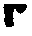

ь


м


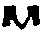

н


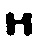

е


ъ


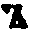

ш


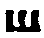

и


In [11]:
char2features = []
for fname in os.listdir(ALPHABET_DIR):
    char = fname.split(".")[0]
    print(char)
    char_img = load_text_image(os.path.join(ALPHABET_DIR, fname))
    display_pillow_image(char_img)
    char_img = ~np.asarray(char_img)
    char_img = delete_space(char_img)
    char_img = resize_image_matrix(char_img, RESIZE_PAIR)
    features = calc_relative_features(char_img)
    char2features += [(char, features)]

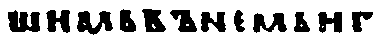

In [12]:
text_image = load_text_image(TEXT_PATH)
display_pillow_image(Image.open(TEXT_PATH))
display_pillow_image(text_image)

In [13]:
text_image_nd = ~np.asarray(text_image)
text_image_nd = delete_space(text_image_nd)
distances = compute_text_distances(text_image_nd, char2features)

In [14]:
pprint(distances)

[[('ш', 0.94), ('и', 0.93), ('н', 0.92), ('ь', 0.9), ('е', 0.9)],
 [('и', 0.95), ('н', 0.94), ('ш', 0.92), ('е', 0.88), ('ь', 0.87)],
 [('м', 0.95), ('г', 0.9), ('ь', 0.89), ('е', 0.89), ('н', 0.89)],
 [('ь', 0.95), ('е', 0.94), ('ш', 0.94), ('в', 0.92), ('и', 0.86)],
 [('в', 0.98), ('е', 0.94), ('ь', 0.93), ('ъ', 0.91), ('ш', 0.89)],
 [('ъ', 0.97), ('в', 0.93), ('е', 0.91), ('г', 0.9), ('ь', 0.89)],
 [('и', 0.96), ('н', 0.94), ('ш', 0.92), ('ь', 0.86), ('е', 0.86)],
 [('е', 0.95), ('ь', 0.94), ('ъ', 0.93), ('в', 0.92), ('г', 0.92)],
 [('м', 0.95), ('н', 0.9), ('ь', 0.89), ('г', 0.89), ('е', 0.88)],
 [('в', 0.94), ('е', 0.94), ('ь', 0.94), ('ъ', 0.92), ('г', 0.89)],
 [('и', 0.98), ('н', 0.96), ('ш', 0.9), ('ь', 0.84), ('е', 0.84)],
 [('г', 0.98), ('е', 0.9), ('ъ', 0.89), ('ь', 0.89), ('м', 0.89)]]


In [15]:
generated_text = ''.join([lst[0][0] for lst in distances])

print(f"TRUE: {GROUND_TRUTH}")
print(f"PRED: {generated_text}")

assert len(generated_text) == len(GROUND_TRUTH)

print(f"Levenshtein = {Levenshtein.distance(GROUND_TRUTH, generated_text)}")

TRUE: шнмьвъиемьнг
PRED: шимьвъиемвиг
Levenshtein = 3
